In [ ]:
!nvidia-smi

Tue Aug 11 07:48:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load Dataset

In [ ]:
mnist_train = datasets.MNIST('.', download=True, train=True, transform=transforms.ToTensor())
mnist_valid = datasets.MNIST('.', download=True, train=False, transform=transforms.ToTensor())

In [ ]:
mnist_train[2000]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

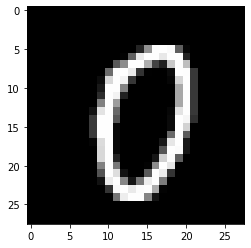

In [ ]:
plt.imshow(mnist_train[1000][0].view(28,28), cmap='gray')

In [ ]:
reduced_label = {3:0, 7:1}

In [ ]:
mnist_train = [(img,reduced_label[lbl]) for img,lbl in mnist_train if lbl in [3,7]]
mnist_valid = [(img,reduced_label[lbl]) for img,lbl in mnist_valid if lbl in [3,7]]

In [ ]:
len(mnist_train), len(mnist_valid)

(12396, 2038)

In [ ]:
trainloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(mnist_valid, batch_size=64, shuffle=False)

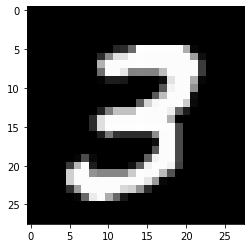

In [ ]:
plt.imshow(mnist_train[0][0].reshape(28,28), cmap='gray')

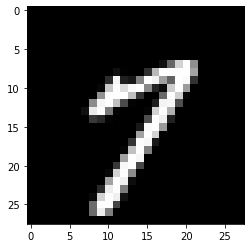

In [ ]:
plt.imshow(mnist_train[4000][0].reshape(28,28), cmap='gray')

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,9,3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(9,18,3, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(2)
        self.mp2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(18*7*7, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self,x):
        x = self.mp1(torch.relu(self.conv1(x)))
        x = self.mp2(torch.relu(self.conv2(x)))
        x = torch.relu(self.fc1(x.view(-1,18*7*7)))
        x = self.fc2(x)
        return x


In [ ]:
model = CNN().cuda()

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=882, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
model(mnist_train[0][0].unsqueeze(0).cuda())

tensor([[ 0.0320, -0.1586]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(10):
    for img,lbl in trainloader:
        img = img.cuda()
        lbl = lbl.cuda()
        y_pred = model(img)
        loss = criterion(y_pred, lbl)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch%2==0:
        model.eval()
        correct = 0.
        total = 0.
        for img,lbl in validloader:
            img = img.cuda()
            lbl = lbl.cuda()
            y_pred = model(img)
            preds = torch.argmax(y_pred,1)
            correct += (preds==lbl).sum()
            total += len(lbl)
        print(epoch, correct/total)

0 tensor(0.9642, device='cuda:0')
2 tensor(0.9715, device='cuda:0')
4 tensor(0.9774, device='cuda:0')
6 tensor(0.9809, device='cuda:0')
8 tensor(0.9848, device='cuda:0')


In [ ]:
model

CNN(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=882, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
model.conv1.weight.shape

torch.Size([9, 1, 3, 3])

In [ ]:
model.conv2.weight.shape

torch.Size([18, 9, 3, 3])

In [ ]:
img = mnist_train[2000][0].unsqueeze(0).cuda()

In [ ]:
model(img)

torch.Size([1, 1, 28, 28])
torch.Size([1, 9, 28, 28])
torch.Size([1, 9, 14, 14])
torch.Size([1, 18, 14, 14])
torch.Size([1, 32])
torch.Size([1, 2])


tensor([[-3.7061,  2.4210]], device='cuda:0', grad_fn=<AddmmBackward>)

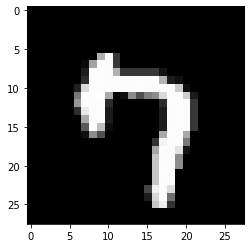

In [ ]:
plt.imshow(img.view(28,28).detach().cpu(), cmap='gray')

In [ ]:
conv1_res = model.conv1(img)
conv1_res.shape



torch.Size([1, 9, 28, 28])

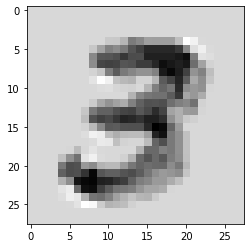

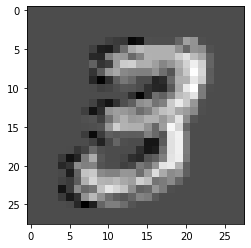

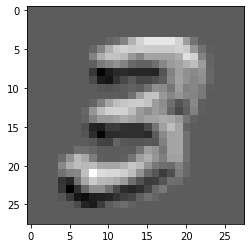

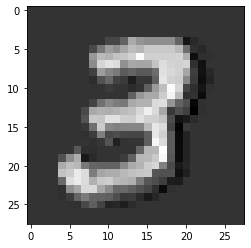

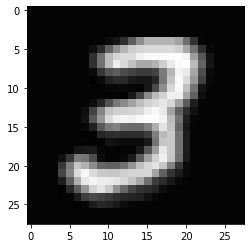

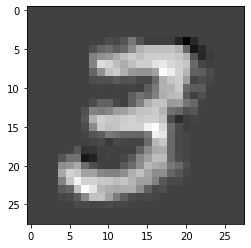

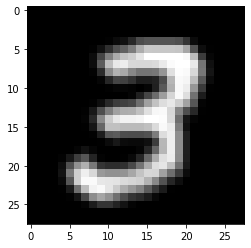

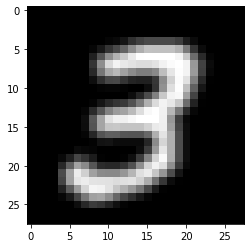

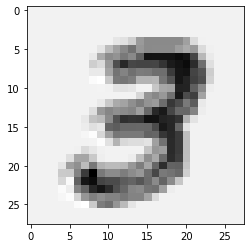

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(9):
    plt.imshow(conv1_res[0][i].detach().cpu(), cmap='gray')
    plt.figure()

In [ ]:
conv1_maps = []
conv2_maps = []
final_input = []
final_output = []

def conv1_acti_maps(self,input,output):
    print(input[0].size())
    print(output.size())
    conv1_maps.append(output)

def conv2_acti_maps(self,input,output):
    print(input[0].size())
    print(output.size())
    conv2_maps.append(output)

def fc_res(self,input,output):
    print(input[0].size())
    print(output.size())
    final_input.append(input[0])
    final_output.append(output)

In [ ]:
model

CNN(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(9, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=882, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
model.conv1.register_forward_hook(conv1_acti_maps)
model.conv2.register_forward_hook(conv2_acti_maps)
model.fc2.register_forward_hook(fc_res)

In [ ]:
model(img)

torch.Size([1, 1, 28, 28])
torch.Size([1, 9, 28, 28])
torch.Size([1, 9, 14, 14])
torch.Size([1, 18, 14, 14])
torch.Size([1, 32])
torch.Size([1, 2])


tensor([[-3.7061,  2.4210]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
def plt_convolutions(conv_list):
    n,c,h,w = conv_list.shape
    conv_list = conv_list.view(c,h,w)
    for i in range(c):
        plt.imshow(conv_list[i], cmap='gray')
        plt.figure()


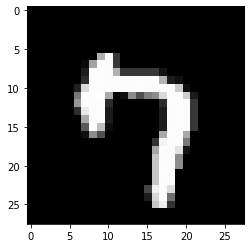

In [ ]:
plt.imshow(img.detach().view(28,28).cpu(), cmap='gray')

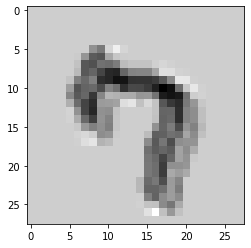

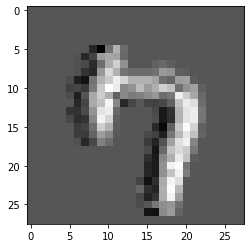

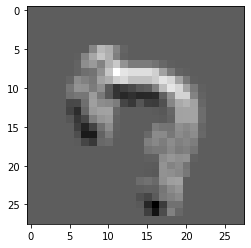

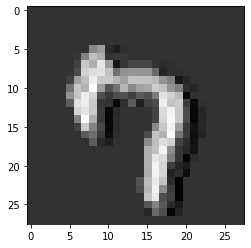

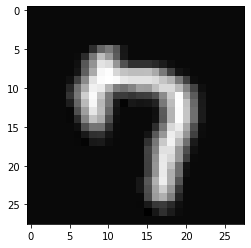

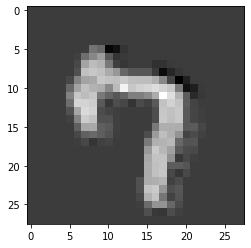

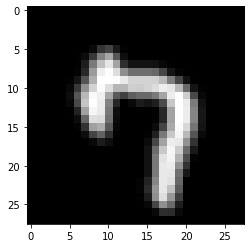

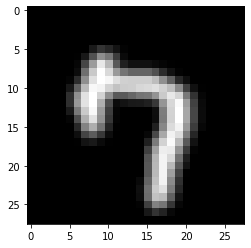

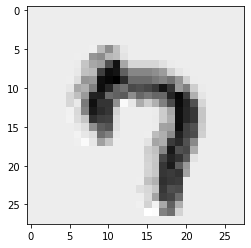

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_convolutions(conv1_maps[0].detach().cpu())

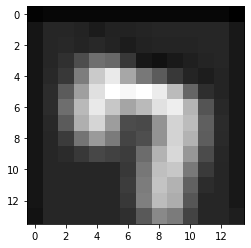

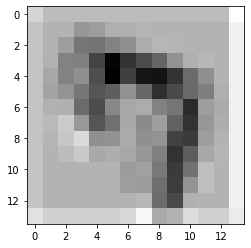

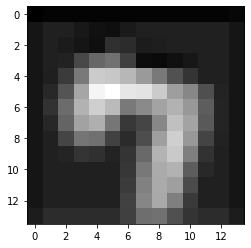

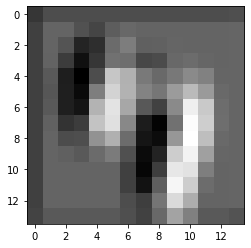

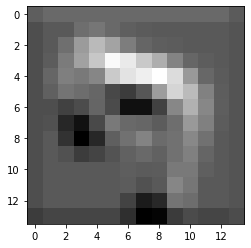

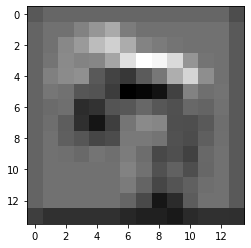

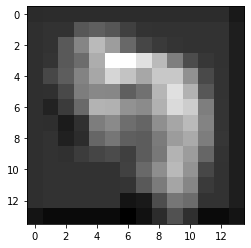

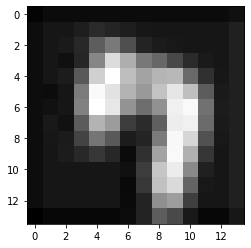

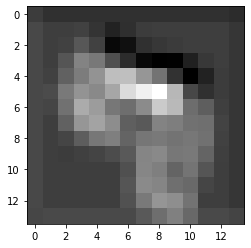

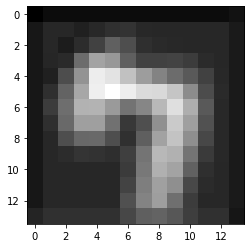

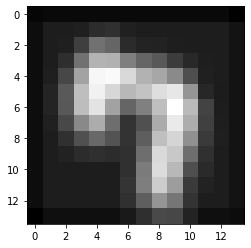

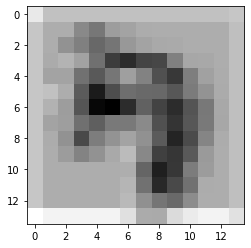

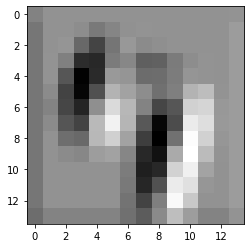

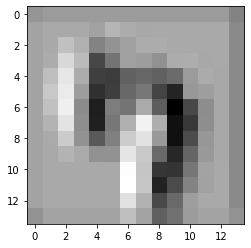

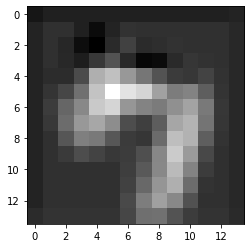

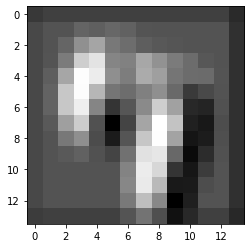

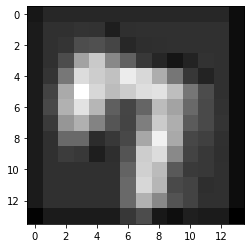

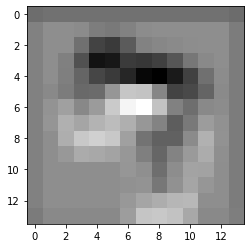

<Figure size 432x288 with 0 Axes>

In [ ]:
plt_convolutions(conv2_maps[0].detach().cpu())

In [ ]:
final_output

[tensor([[-3.7061,  2.4210]], device='cuda:0', grad_fn=<AddmmBackward>)]

In [ ]:
final_input

[tensor([[0.0000, 0.0861, 0.0000, 0.0000, 0.0000, 0.2379, 0.0919, 2.1521, 0.2923,
          2.1125, 0.2293, 0.5945, 0.0000, 0.0000, 0.3882, 0.2749, 2.1746, 2.2501,
          2.3925, 2.5038, 2.2681, 0.0000, 2.5527, 0.2392, 0.3030, 0.3724, 2.1637,
          0.0000, 0.3130, 0.3783, 2.0129, 2.2829]], device='cuda:0',
        grad_fn=<ReluBackward0>)]

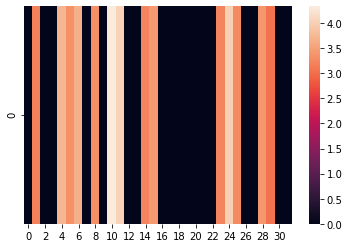

In [ ]:
#3
sns.heatmap([final_input[0][0].detach().cpu().numpy()])

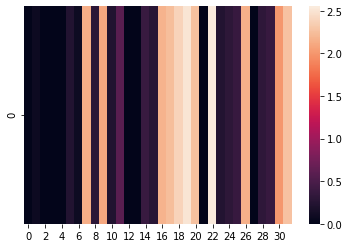

In [ ]:
#7
sns.heatmap([final_input[0][0].detach().cpu().numpy()])